In [1]:
from tensorflow.keras.regularizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import *
from tensorflow.keras.datasets import *
from tensorflow.keras.utils import to_categorical
import plotting
from tensorflow import keras

from qkeras import *
from qkeras.codebook import *
import os
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from matplotlib.lines import Line2D
from matplotlib.legend import Legend

BIT_WIDTH = 4
NUM_TRAIN_SAMPLES = 1000
NUM_VAL_SAMPLES = 100


def get_data(name, sample_size=1.0):
    (x_train, y_train), (x_test, y_test) = globals()[name].load_data()

    x_train = np.resize(x_train[0:NUM_TRAIN_SAMPLES], (NUM_TRAIN_SAMPLES, 256, 256, 3))
    x_test = np.resize(x_test[0:NUM_VAL_SAMPLES], (NUM_VAL_SAMPLES, 256, 256, 3))
    y_train = y_train[0:NUM_TRAIN_SAMPLES, ...]
    y_test = y_test[0:NUM_VAL_SAMPLES, ...]

    if len(x_train.shape) == 3:
        x_train = x_train.reshape(x_train.shape + (1,))
        x_test = x_test.reshape(x_test.shape + (1,))

    x_train = x_train.astype("float32")
    x_test = x_test.astype("float32")

    mean = np.mean(x_train, axis=(0, 1, 2, 3))
    std = np.std(x_train, axis=(0, 1, 2, 3))
    x_train = (x_train - mean) / (std + 1e-7)
    x_test = (x_test - mean) / (std + 1e-7)

    y_train_c = to_categorical(y_train, np.max(y_train) + 1)
    y_test_c = to_categorical(y_test, np.max(y_test) + 1)

    if sample_size != 1.0:
        indexes = np.asarray(range(x_train.shape[0]))
        np.random.shuffle(indexes)
        indexes = indexes[: int(x_train.shape[0] * sample_size)]

        x_train = x_train[indexes]
        y_train_c = y_train_c[indexes]

    return (x_train, y_train_c), (x_test, y_test_c)


def get_model(
    name,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=10,
):

    X_shape = X_train.shape[1:]
    x_i = x = Input(X_shape)

    x = QActivation(quantized_relu(BIT_WIDTH, 0))(x)
    x = QDepthwiseConv2D(
        3,
        strides=3,
        depthwise_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
        bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
    )(x)
    x = QActivation(quantized_tanh(BIT_WIDTH, 0))(x)
    x = QConv2D(
        24,
        5,
        2,
        kernel_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
        bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
    )(x)
    x = QActivation(quantized_tanh(BIT_WIDTH, 0))(x)
    x = QDepthwiseConv2D(
        4,
        strides=4,
        depthwise_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
        bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
    )(x)
    x = QActivation(quantized_relu(BIT_WIDTH, 0))(x)
    x = QConv2D(
        40,
        1,
        1,
        kernel_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
        bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
    )(x)
    x = QActivation(quantized_bits(BIT_WIDTH, 0, 1))(x)
    x = Flatten()(x)
    x = QDense(
        10,
        kernel_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
        bias_quantizer=quantized_bits(BIT_WIDTH, 0, 1),
    )(x)
    # x = Activation("softmax")(x)

    model = Model(inputs=x_i, outputs=x)
    model.summary()

    model.compile(
        loss=keras.losses.CategoricalCrossentropy(True), optimizer=Adam(0.001), metrics=["acc"]
    )

    model.fit(
        X_train,
        y_train,
        validation_data=(X_test, y_test),
        batch_size=128,
        epochs=epochs,
        verbose=2,
    )
    model.save_weights(name + ".h5")

    return model


name = "cifar10_with_DW"
(X_train, y_train), (X_test, y_test) = get_data("cifar10", sample_size=1)
model = get_model(
    name,
    X_train,
    y_train,
    X_test,
    y_test,
    epochs=2,
)

2024-02-03 13:35:43.686699: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-03 13:35:43.711461: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 13:35:43.711493: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 13:35:43.712373: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 13:35:43.717507: I tensorflow/core/platform/cpu_feature_guar

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 q_activation (QActivation)  (None, 256, 256, 3)       0         
                                                                 
 q_depthwise_conv2d (QDepth  (None, 85, 85, 3)         30        
 wiseConv2D)                                                     
                                                                 
 q_activation_1 (QActivatio  (None, 85, 85, 3)         0         
 n)                                                              
                                                                 
 q_conv2d (QConv2D)          (None, 41, 41, 24)        1824      
                                                                 
 q_activation_2 (QActivatio  (None, 41, 41, 24)        0     

2024-02-03 13:35:50.382886: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape ingradient_tape/model/q_activation_3/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-02-03 13:35:52.191230: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-03 13:35:52.817382: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f77a98f5000 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-03 13:35:52.817398: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-02-03 13:35:52.820356: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706978152.876582  107474 device_compiler.h:186] Compiled cluster 

8/8 - 6s - loss: 2.3306 - acc: 0.1120 - val_loss: 2.3218 - val_acc: 0.0900 - 6s/epoch - 803ms/step
Epoch 2/2
8/8 - 0s - loss: 2.2532 - acc: 0.1770 - val_loss: 2.3221 - val_acc: 0.0800 - 363ms/epoch - 45ms/step


In [2]:
model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 18ms/step - loss: 2.3221 - acc: 0.0800


[2.3221466541290283, 0.07999999821186066]

In [3]:
from qkeras.estimate import print_qstats
print_qstats(model)

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.



Number of operations in model:
    q_conv2d                      : 3025800 (smult_4_4)
    q_conv2d_1                    : 96000 (smult_4_4)
    q_dense                       : 40000 (smult_4_4)
    q_depthwise_conv2d            : 195075 (smult_4_4)
    q_depthwise_conv2d_1          : 38400 (smult_4_4)

Number of operation types in model:
    smult_4_4                     : 3395275

Weight profiling:
    q_conv2d_weights               : 1800  (4-bit unit)
    q_conv2d_bias                  : 24    (4-bit unit)
    q_conv2d_1_weights             : 960   (4-bit unit)
    q_conv2d_1_bias                : 40    (4-bit unit)
    q_dense_weights                : 40000 (4-bit unit)
    q_dense_bias                   : 10    (4-bit unit)
    q_depthwise_conv2d_weights     : 81    (4-bit unit)
    q_depthwise_conv2d_bias        : 3     (4-bit unit)
    q_depthwise_conv2d_1_weights   : 9216  (4-bit unit)
    q_depthwise_conv2d_1_bias      : 24    (4-bit unit)

Weight sparsity:
... quantizing mo

# create HLS4MLModel

In [4]:
import hls4ml

config = hls4ml.utils.config_from_keras_model(
    model,
    granularity="name",
    default_precision="fixed<4,4>",
    default_reuse_factor=2048,
)


config["LayerName"]["q_depthwise_conv2d"]["Strategy"] = "Latency"
config["LayerName"]["q_depthwise_conv2d_1"]["Strategy"] = "Latency"
config["Model"]["Strategy"] = "Resource"


print("-----------------------------------")
print("Configuration")
plotting.print_dict(config)
print("-----------------------------------")



/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/hls4ml/converters/__init__.py:27: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!", stacklevel=1)


Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_depthwise_conv2d, layer type: QDepthwiseConv2D, input shapes: [[None, 256, 256, 3]], output shape: [None, 85, 85, 3]
Layer name: q_activation_1, layer type: HardActivation, input shapes: [[None, 85, 85, 3]], output shape: [None, 85, 85, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 85, 85, 3]], output shape: [None, 41, 41, 24]
Layer name: q_activation_2, layer type: HardActivation, input shapes: [[None, 41, 41, 24]], output shape: [None, 41, 41, 24]
Layer name: q_depthwise_conv2d_1, layer type: QDepthwiseConv2D, input shapes: [[None, 41, 41, 24]], output shape: [None, 10, 10, 24]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 10, 10, 24]], output shape: [None, 10

/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [5]:


hls_model = hls4ml.converters.convert_from_keras_model(
    model,
    hls_config=config,
    output_dir=f"model_qtest/hls4ml_prj",
    part="xc7z020-clg400-1",
    io_type="io_stream",
)

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_activation, layer type: Activation, input shapes: [[None, 256, 256, 3]], output shape: [None, 256, 256, 3]
Layer name: q_depthwise_conv2d, layer type: QDepthwiseConv2D, input shapes: [[None, 256, 256, 3]], output shape: [None, 85, 85, 3]
Layer name: q_activation_1, layer type: HardActivation, input shapes: [[None, 85, 85, 3]], output shape: [None, 85, 85, 3]
Layer name: q_conv2d, layer type: QConv2D, input shapes: [[None, 85, 85, 3]], output shape: [None, 41, 41, 24]
Layer name: q_activation_2, layer type: HardActivation, input shapes: [[None, 41, 41, 24]], output shape: [None, 41, 41, 24]
Layer name: q_depthwise_conv2d_1, layer type: QDepthwiseConv2D, input shapes: [[None, 41, 41, 24]], output shape: [None, 10, 10, 24]
Layer name: q_activation_3, layer type: Activation, input shapes: [[None, 10, 10, 24]], output shape: [None, 10

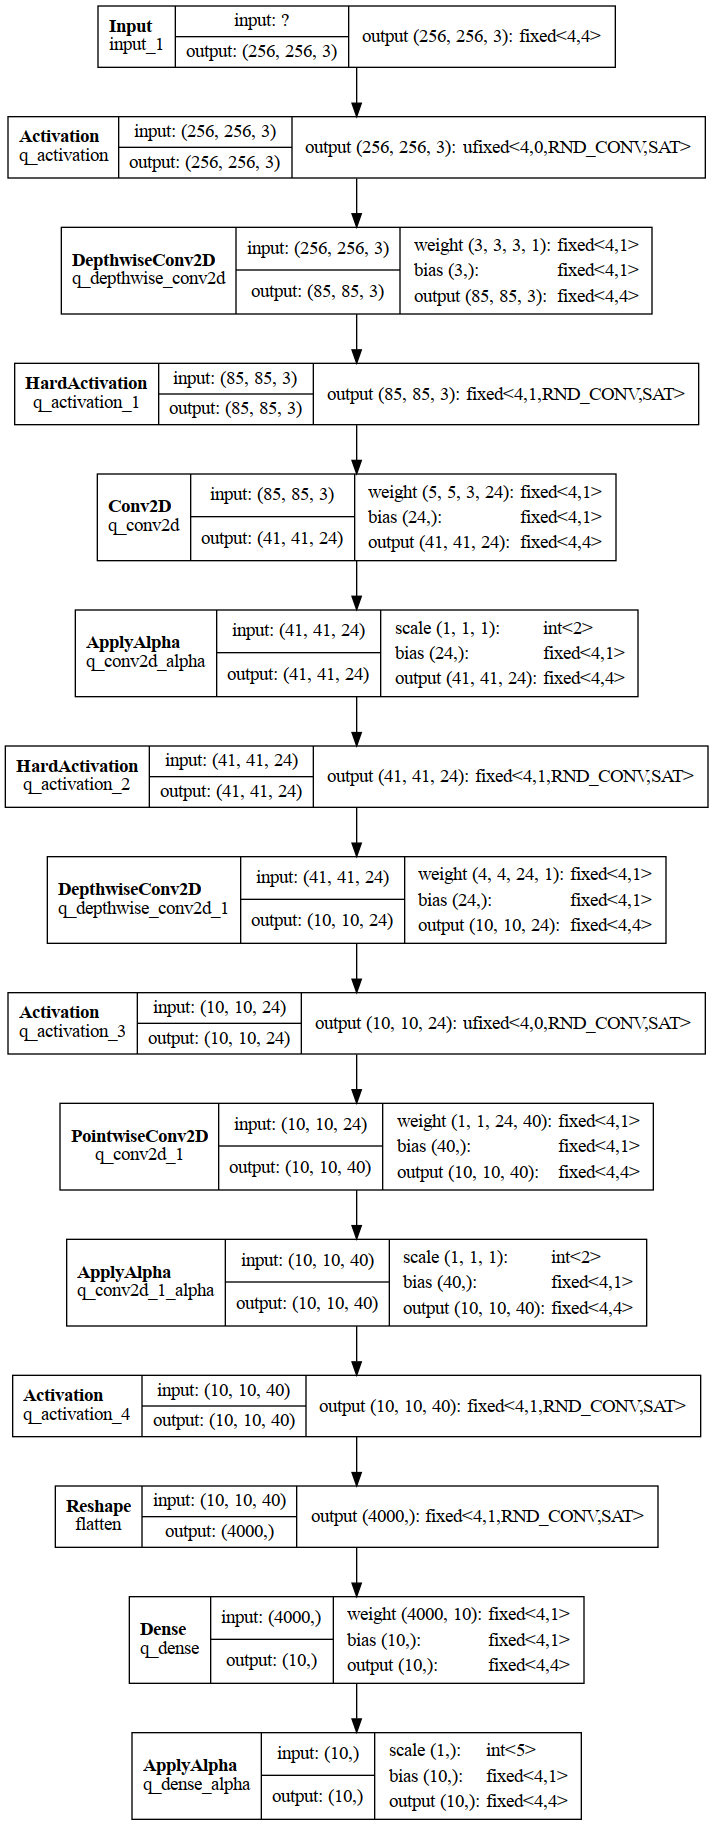

In [6]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

# compile hls4ml model

In [7]:
hls_model.compile()

Writing HLS project


/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/home/webphy/Desktop/dnn_processor/.venv/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Done
starting compile....
backend FPGA model_qtest/hls4ml_prj
trying bash build lib.sh
Ok
lib_name model_qtest/hls4ml_prj/firmware/myproject-532C6Abe.so
backend compiled.... model_qtest/hls4ml_prj/firmware/myproject-532C6Abe.so
compiled....


In [ ]:

# classes = ["0", "1", "2", "3", "4"]
# 
# val_ds_np = np.ascontiguousarray(X_test).astype(np.float32)
# y_hls = hls_model.predict(val_ds_np)
# 
# print(
#     "hls4ml Accuracy: {}".format(
#         accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))
#     )
# )
# 
# fig, ax = plt.subplots(figsize=(9, 9))
# plt.gca().set_prop_cycle(None)  # reset the colors
# _ = plotting.makeRoc(y_test, y_hls, classes, linestyle="--")
# 
# lines = [Line2D([0], [0], ls="--")]
# 
# leg = Legend(ax, lines, labels=["hls4ml"], loc="lower right", frameon=False)
# ax.add_artist(leg)

# build hls4ml

In [8]:
hls_model.build(csim=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2020.1 (64-bit)
  **** SW Build 2902540 on Wed May 27 19:54:35 MDT 2020
  **** IP Build 2902112 on Wed May 27 22:43:36 MDT 2020
    ** Copyright 1986-2020 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2020.1/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2020.1/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'webphy' on host 'douglas-XPS-8950' (Linux_x86_64 version 6.5.0-15-generic) on Sat Feb 03 13:37:43 -03 2024
INFO: [HLS 200-10] On os Ubuntu 22.04.3 LTS
INFO: [HLS 200-10] In directory '/home/webphy/Desktop/dnn_processor/hls4ml/model_qtest/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/webphy/Desktop/dnn_processor/hls4ml/model_qtest/hls4ml_prj/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the pr

In [ ]:
hls4ml.report.read_vivado_report(f"model_qtest/hls4ml_prj/")